In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.decision_sets.pruning import *
from intercluster.experiments import *
%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [38]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

subset_outlier_colors = ['grey', cmap(5), cmap(6), cmap(7)]
cmap_subset_outliers = ListedColormap(subset_outlier_colors)

subset_colors2 = ['red', cmap(5), cmap(6)]
cmap_subset2 = ListedColormap(subset_colors2)

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (doing so, however, will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

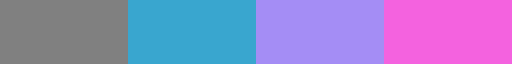

In [39]:
cmap_subset_outliers

## Example Setting

In [5]:
n = 1000
k = 2
data, labels = datasets.make_moons(n_samples = n, noise = 0.05, random_state = seed)

#data, labels = datasets.make_circles(n_samples=n, factor=0.5, noise=0.05, random_state=seed)

In [51]:
n_samples = 500
seed = 30

# ============
# Toy datasets from sci-kit learn's clustering examples:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
# ============

# Circles
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)

# Moons
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

# Blobs
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [52]:
data,labels = aniso
k = 3

Text(0, 0.5, 'y')

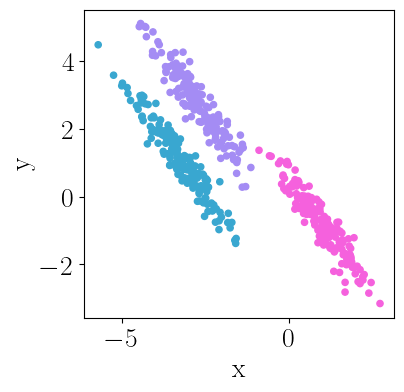

In [53]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap_subset, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [47]:
distances = pairwise_distances(data, metric='euclidean')
density_distances = density_distance(data)

In [48]:
cluster1 = np.where(labels == 0)[0]
cluster2 = np.where(labels == 1)[0]
between_cluster_distances = distances[cluster1,:]
between_cluster_distances = between_cluster_distances[:,cluster2]
print("Minimum between cluster distance: ", np.min(between_cluster_distances))

between_cluster_density_distances = density_distances[cluster1,:]
between_cluster_density_distances = between_cluster_density_distances[:,cluster2]
print("Minimum between cluster density distance: ", np.min(between_cluster_density_distances))

within_cluster_density_distances = density_distances[cluster2,:]
within_cluster_density_distances = within_cluster_density_distances[:,cluster2]
print("Max between cluster density distance: ", np.max(within_cluster_density_distances))

Minimum between cluster distance:  0.5338346738920698
Minimum between cluster density distance:  0.5338346738920698
Max between cluster density distance:  0.4451373232100903


### DBSCAN Reference Clustering

In [93]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data)
dbscan_labels = labels_format(dbscan.labels_)
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = k, ignore = {-1})

Text(0, 0.5, 'y')

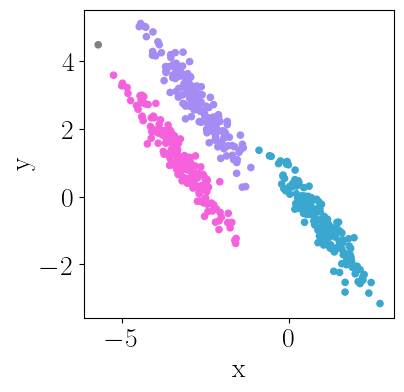

In [94]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = dbscan.labels_, cmap = cmap_subset_outliers, s = 20)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [95]:
coverage(dbscan_assignment)

0.998

In [96]:
silhouette_score(data, dbscan_assignment)

0.4696827481062687

### Standard Decision Tree

In [118]:
tree = SklearnTree(max_leaf_nodes = 5)
tree.fit(data, dbscan_labels)
tree_labels = tree.predict(data)
tree_labels = [label if label == dbscan_labels[i] else {-1} for i,label in enumerate(tree_labels)]
tree_labels_ = flatten_labels(tree_labels)
tree_assignment = labels_to_assignment(tree_labels, n_labels = k, ignore = {-1})

Text(0, 0.5, 'y')

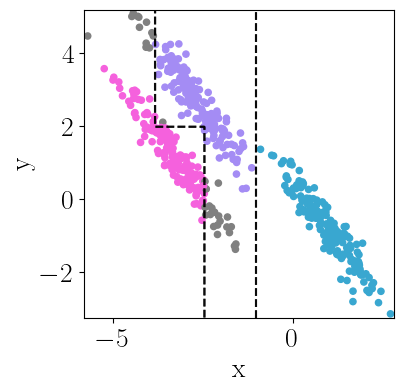

In [119]:
# Visualize the partition
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = tree_labels_, cmap = cmap_subset_outliers, s = 20)
plot_decision_boundaries(tree, data, ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [120]:
coverage(tree_assignment)

0.928

In [121]:
silhouette_score(data, tree_assignment)

0.5012944668474116

In [122]:
tree.get_weighted_average_depth(data)

2.336

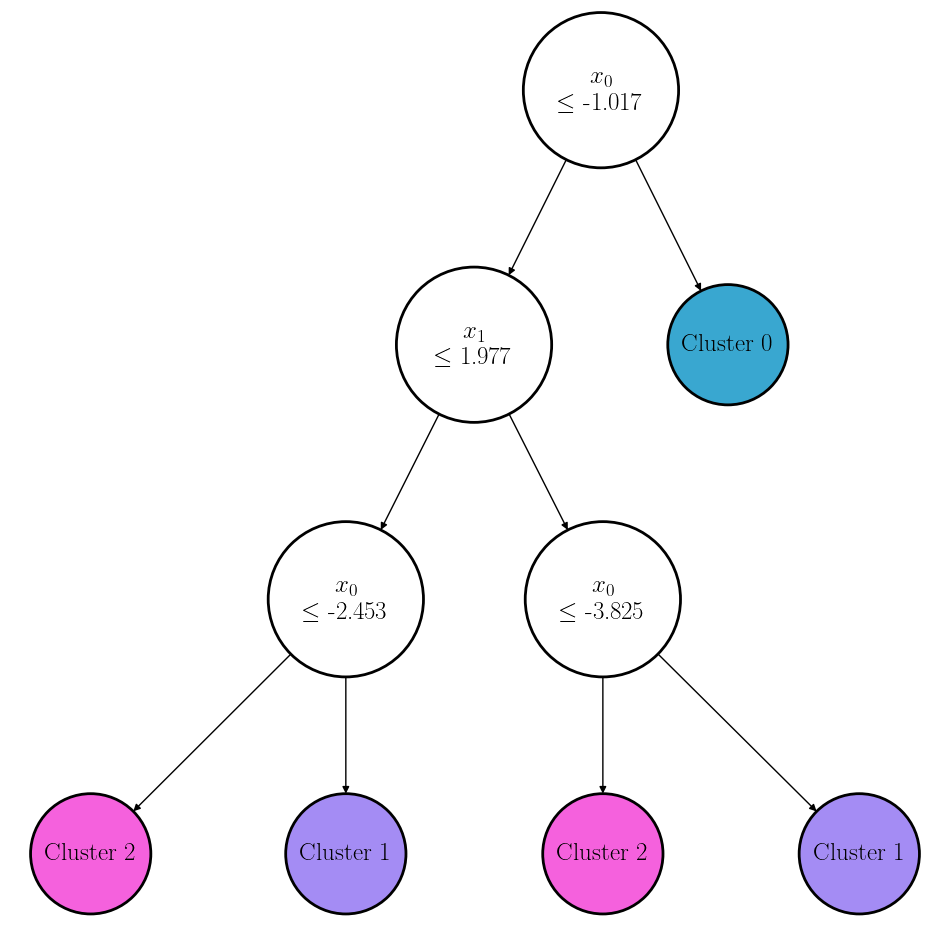

In [123]:
draw_tree(tree.root, cmap = cmap_subset)

### Mistake Minimization Tree

Next, we show an implementation for the what we call the Explanation Tree algorithm, 
designed by Bandyapadhyay et al. in their work "How to find a good explanation for clustering?"
The algorithm works by removing outliers during the training process, aiming to find a minimal 
number of points to remove so that the resulting tree exactly replicates KMeans on everything 
that remains.

In [73]:
mm_tree = ExplanationTree(num_clusters = k)
mm_tree.fit(data, dbscan_labels)
mm_labels = mm_tree.predict(data, remove_outliers = True)
mm_labels_ = flatten_labels(mm_labels)
mm_assignment = labels_to_assignment(mm_labels, n_labels = k, ignore = {-1})

Text(0, 0.5, 'y')

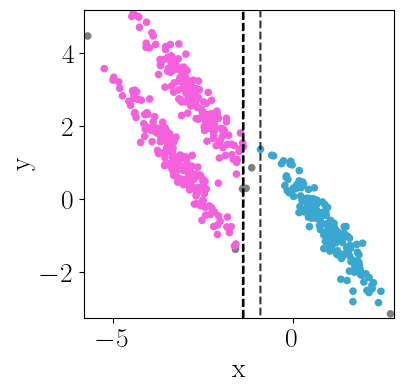

In [74]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = mm_labels_, cmap = cmap_subset_outliers, s = 20)

plot_decision_boundaries(mm_tree, data, ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [75]:
coverage(mm_assignment)

0.988

In [76]:
silhouette_score(data, mm_assignment)

0.6415845343939574

In [77]:
mm_tree.get_weighted_average_depth(data)

1.6673387096774193

### Density Based Decision Set

In [113]:
db_set = DBSet(n_rules = 5, n_features = 2, epsilon = 0.45, mu = 5, rules_per_point = 1)
db_set.fit(data)
db_set_labels = db_set.predict(data)
db_set_labels_ = flatten_labels(db_set_labels)
unique_labels = len(np.unique(db_set_labels_))
db_set_assignment = labels_to_assignment(db_set_labels, n_labels = unique_labels, ignore = {-1})

Text(0, 0.5, 'y')

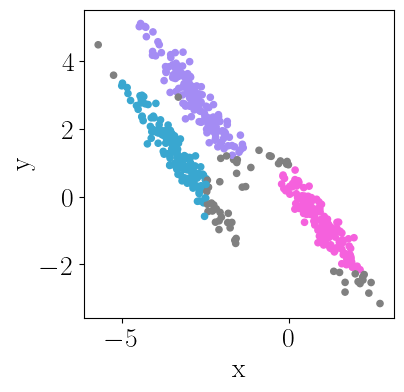

In [114]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = db_set_labels_, cmap = cmap_subset_outliers, s = 20)

#plot_decision_boundaries(db_set, data, ax = ax, resolution = 1000)

ax.set_xlabel('x')
ax.set_ylabel('y')

In [115]:
coverage(db_set_assignment)

0.886

In [116]:
silhouette_score(data, db_set_assignment)

0.5206929175537777

In [117]:
db_set.get_weighted_average_rule_length(data)

2.5404858299595143

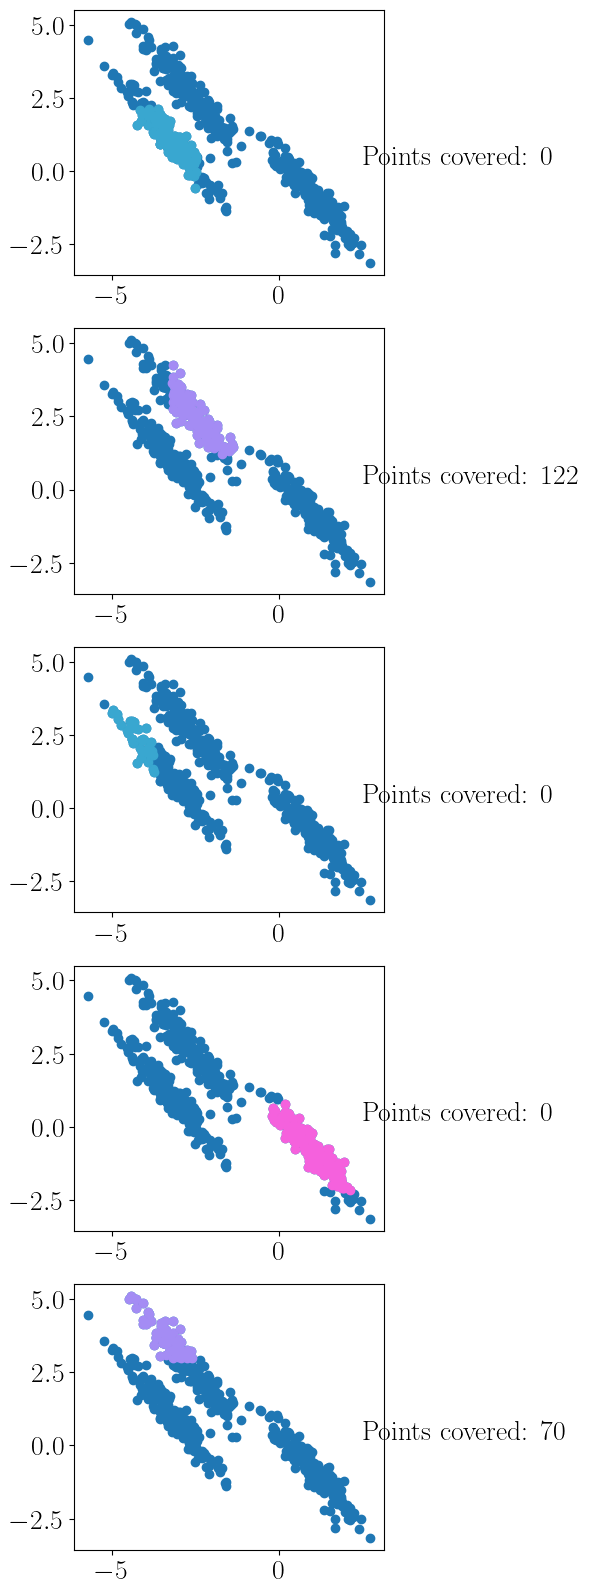

In [124]:
# Then visualize what's covered by each of the rules:
ld = len(db_set.decision_set[:10])
fig, ax = plt.subplots(ld, 1, figsize = (4,4 * ld))

for i, condition_list in enumerate(db_set.decision_set[:10]):
    r_label = list(db_set.decision_set_labels[:10][i])[0]
    indices = satisfies_conditions(data, condition_list)
    points_covered = np.sum(dbscan.labels_[indices] == r_label)
    n_overlaps = len(indices) - np.sum(dbscan.labels_[indices] == r_label)
    if ld > 1:
        ax[i].scatter(data[:, 0], data[:, 1])
        ax[i].scatter(data[indices, 0], data[indices, 1], color = cmap_subset(r_label))
        ax[i].text(x = 2.5, y = 0.2, s = "Points covered: " + str(points_covered), ha = 'left')
        #ax[i].text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')
    else:
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(data[indices, 0], data[indices, 1], color = cmap(r_label))
        ax.text(x = 2.5, y = 0.2, s = "Points covered: " + str(points_covered), ha = 'left')
        #ax.text(x = 2.5, y = 0, s = "Overlap with other clusters: " + str(n_overlaps), ha = 'left')

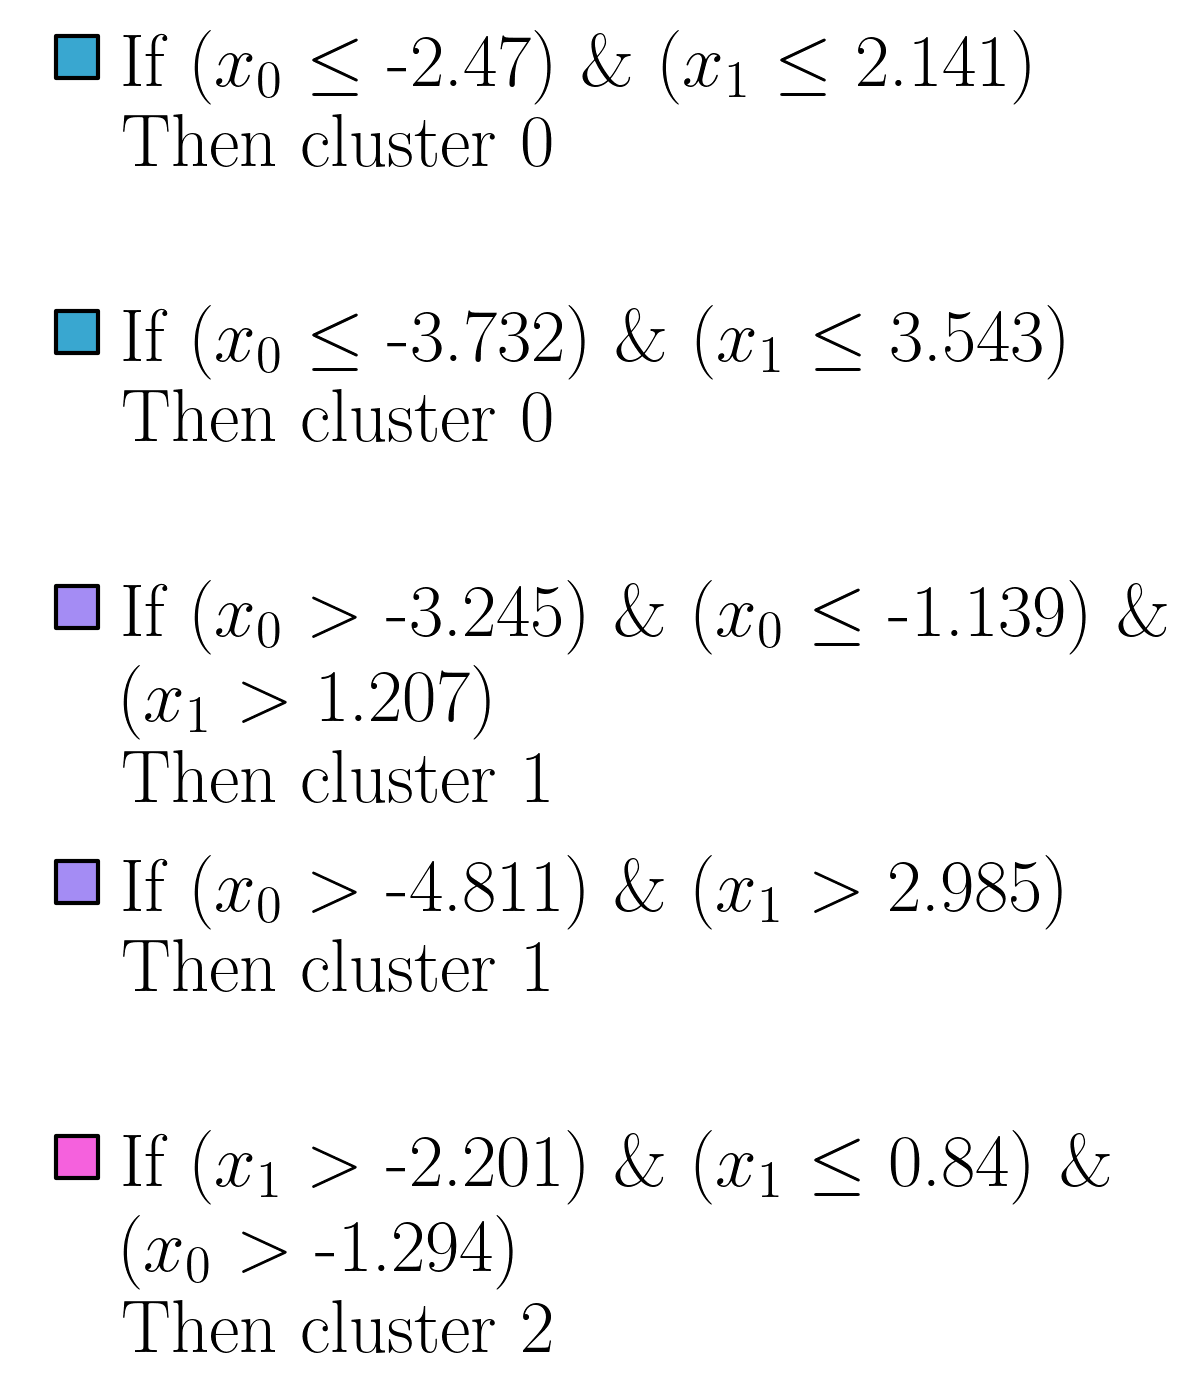

In [125]:
# Finally, we plot the pruned set of rules.
pruned_set = db_set.decision_set[:10]
pruned_rule_labels = db_set.decision_set_labels[:10]
plot_decision_set(
    decision_set = pruned_set,
    rule_labels = pruned_rule_labels,
    cmap = cmap_subset,
)

## Experiments

#### Varying the maximum number of rules

In [128]:
# Baseline DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data)
dbscan_labels = labels_format(dbscan.labels_)
dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = k, ignore = {-1})
dbscan_coverage = coverage(dbscan_assignment)
dbscan_silhouette = silhouette_score(data, dbscan_assignment)

# Baseline Mistake Minimization tree
mm_tree = ExplanationTree(num_clusters = k)
mm_tree.fit(data, dbscan_labels)
mm_tree_labels = mm_tree.predict(data, remove_outliers = True)
mm_tree_labels_ = flatten_labels(mm_tree_labels)
mm_tree_assignment = labels_to_assignment(mm_tree_labels, n_labels = k, ignore = {-1})
mm_tree_coverage = coverage(mm_tree_assignment)
mm_tree_silhouette = silhouette_score(data, mm_assignment)
mm_tree_wad = mm_tree.get_weighted_average_depth(data)

# Domain
rule_domain = np.arange(2,20)

# DBSCAN results
dbscan_coverages = np.array([dbscan_coverage] * len(rule_domain))
dbscan_silhouettes = np.array([dbscan_silhouette] * len(rule_domain))

# Mistake Minimization results
mm_tree_coverages = np.array([mm_tree_coverage] * len(rule_domain))
mm_tree_silhouettes = np.array([mm_tree_silhouette] * len(rule_domain))
mm_tree_wads = np.array([mm_tree_wad] * len(rule_domain))

# Decision tree results
tree_coverages = np.zeros(len(rule_domain))
tree_silhouettes = np.zeros(len(rule_domain))
tree_wads = np.zeros(len(rule_domain))

# Density-Based Decision Set results
n_features = 2
epsilon = 1/3
rules_per_point = 3
samples = 3
db_set_coverages = np.zeros((samples, len(rule_domain)))
db_set_silhouettes = np.zeros((samples, len(rule_domain)))
db_set_wads = np.zeros((samples, len(rule_domain)))

for i, n_rules in enumerate(rule_domain):
    # Decision Tree with nrules
    tree = SklearnTree(max_leaf_nodes = n_rules)
    tree.fit(data, dbscan_labels)
    tree_labels = tree.predict(data)
    tree_labels = [label if label == dbscan_labels[i] else {-1} for i,label in enumerate(tree_labels)]
    tree_labels_ = flatten_labels(tree_labels)
    tree_assignment = labels_to_assignment(tree_labels, n_labels = k, ignore = {-1})
    tree_coverages[i] = coverage(tree_assignment)
    tree_silhouettes[i] = silhouette_score(data, tree_assignment)
    tree_wads[i] = tree.get_weighted_average_depth(data)

    # Decision Set with nrules
    for j in range(samples):
        db_set = DBSet(n_rules = n_rules, n_features = 2, epsilon = 0.45, mu = 5, rules_per_point = 1)
        db_set.fit(data)
        db_set_labels = db_set.predict(data)
        db_set_labels_ = flatten_labels(db_set_labels)
        unique_labels = len(np.unique(db_set_labels_))
        db_set_assignment = labels_to_assignment(db_set_labels, n_labels = unique_labels, ignore = {-1})
        db_set_coverages[j,i] = coverage(db_set_assignment)
        db_set_silhouettes[j,i] = silhouette_score(data, db_set_assignment)
        db_set_wads[j,i] = db_set.get_weighted_average_rule_length(data)

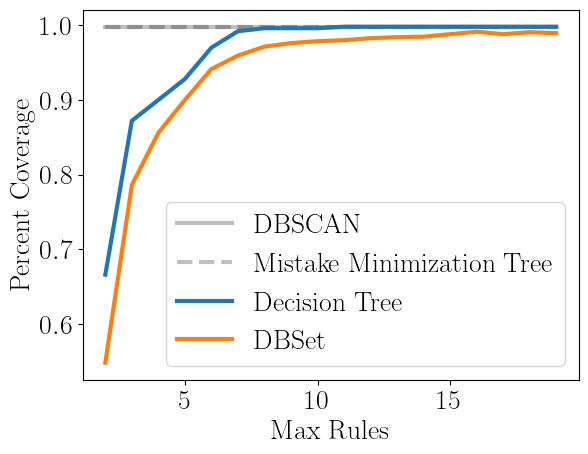

In [129]:
fix, ax = plt.subplots()
ax.plot(rule_domain, dbscan_coverages, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
ax.plot(rule_domain, mm_tree_coverages, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
ax.plot(rule_domain, tree_coverages, linewidth = 3, label = 'Decision Tree')
ax.plot(rule_domain, np.mean(db_set_coverages, axis = 0), linewidth = 3, label = 'DBSet')
ax.set_xlabel('Max Rules')
ax.set_ylabel('Percent Coverage')
plt.legend()

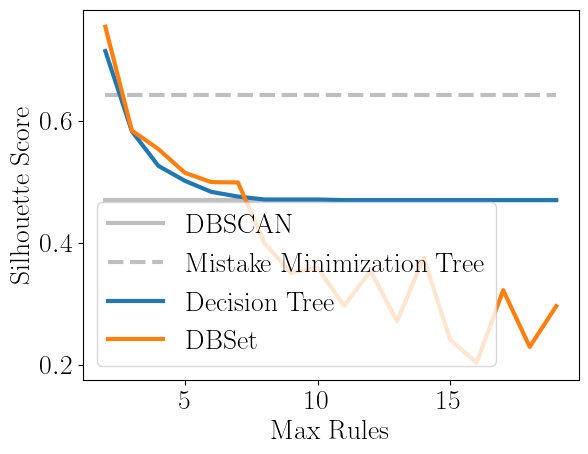

In [130]:
fix, ax = plt.subplots()
ax.plot(rule_domain, dbscan_silhouettes, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
ax.plot(rule_domain, mm_tree_silhouettes, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
ax.plot(rule_domain, tree_silhouettes, linewidth = 3, label = 'Decision Tree')
ax.plot(rule_domain, np.mean(db_set_silhouettes, axis = 0), linewidth = 3, label = 'DBSet')
ax.set_xlabel('Max Rules')
ax.set_ylabel('Silhouette Score')
plt.legend()

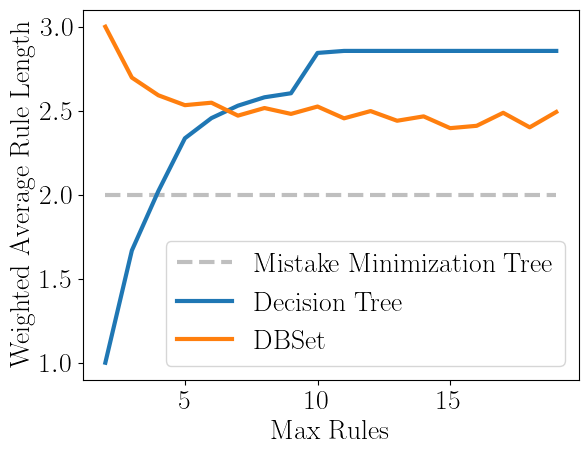

In [131]:
fix, ax = plt.subplots()
#ax.plot(rule_domain, dbscan_wads, linewidth = 3, label = 'DBSCAN', color = 'k', alpha = 0.25)
ax.plot(rule_domain, mm_tree_wads, linewidth = 3, label = 'Mistake Minimization Tree', linestyle = '--', color = 'k', alpha = 0.25)
ax.plot(rule_domain, tree_wads, linewidth = 3, label = 'Decision Tree')
ax.plot(rule_domain, np.mean(db_set_wads, axis = 0), linewidth = 3, label = 'DBSet')
ax.set_xlabel('Max Rules')
ax.set_ylabel('Weighted Average Rule Length')
plt.legend()

### Evaluation

In [26]:
def coverage_mistake_objective(
    X,
    y,
    decision_set,
    lambd : float = 1
):
    if not can_flatten(y):
        raise ValueError("Each data point must have exactly one label.")
    y_ = flatten_labels(y)
    k = len(np.unique(y_))

    if decision_set.pruned_indices is None:
        raise ValueError("The decision set has not been pruned")

    selected = decision_set.pruned_indices
    data_to_rules_assignment = decision_set.get_pruned_data_to_rules_assignment(X)
    rules_to_clusters_assignment = decision_set.get_pruned_rules_to_clusters_assignment(n_labels = k)
    data_to_clusters_assignment = (data_to_rules_assignment @ rules_to_clusters_assignment).astype(bool)
                
    cover = coverage(data_to_clusters_assignment, percentage = False)
    mistakes = 0
    for i in range(k):
        cluster_rules = np.where(rules_to_clusters_assignment[:,i])[0]
        for rule in cluster_rules:
            rule_points = np.where(data_to_rules_assignment[:,rule])[0]
            for point in rule_points:
                if y_[point] != i:
                    mistakes += 1
                    
    return cover - lambd * mistakes
        

In [27]:
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)
prune_objective = CoverageObjective()

decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))
explanation_tree_removals = len(exp_tree.outliers)

In [33]:
# With changing lambda value:
lambda_range = np.linspace(0,2,21)
max_rules = 5

lambda_evals = np.zeros(len(lambda_range))
forest_lambda_evals = np.zeros(len(lambda_range))
decision_tree_lambda_evals = np.zeros(len(lambda_range))
explanation_tree_lambda_evals = np.zeros(len(lambda_range))

# Decision Tree
tree = SklearnTree(max_leaf_nodes = max_rules)
tree.fit(data, dbscan_labels)
y_tree = flatten_labels(tree.predict(data))
decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))

# Explanation Tree
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, dbscan_labels)
explanation_tree_removals = len(exp_tree.outliers)

# Decision Forest 
feature_pairings = [[0, 1]]
forest_tree_params = {
    'max_depth' : 4
}
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)
forest.fit(data, dbscan_labels)

# Point Set
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)

prune_objective = CoverageObjective()
for i,l in enumerate(lambda_range):
    point_set.prune(
        n_rules = max_rules,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = dbscan_labels,
        objective = prune_objective,
        lambda_search_range = [l]        
    )
    forest.prune(
        n_rules = max_rules,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = labels_format(dbscan.labels_),
        objective = prune_objective,
        lambda_search_range = [l] 
        
    )
    lambda_evals[i] = coverage_mistake_objective(data, dbscan_labels, point_set, lambd = l)
    forest_lambda_evals[i] = coverage_mistake_objective(data, dbscan_labels, forest, lambd = l)
    if l < 1:
        decision_tree_lambda_evals[i] = len(data) - l * decision_tree_mistakes
    else:
        decision_tree_lambda_evals[i] = len(data) - decision_tree_mistakes
    explanation_tree_lambda_evals[i] = (len(data) - explanation_tree_removals)

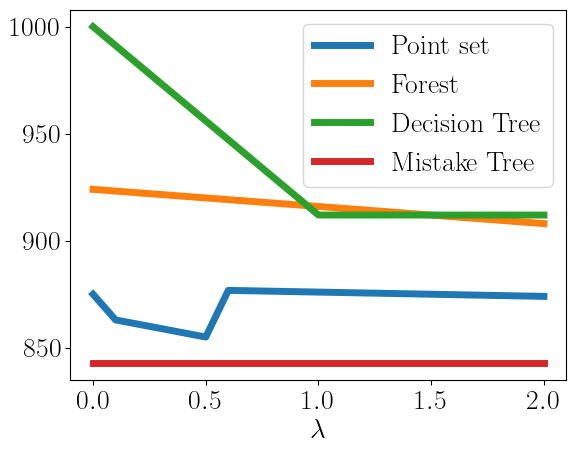

In [34]:
fix, ax = plt.subplots()
ax.plot(lambda_range, lambda_evals, linewidth = 5, label = 'Point set')
ax.plot(lambda_range, forest_lambda_evals, linewidth = 5, label = 'Forest')
ax.plot(lambda_range, decision_tree_lambda_evals, linewidth = 5, label = 'Decision Tree')
ax.plot(lambda_range, explanation_tree_lambda_evals, linewidth = 5, label = 'Mistake Tree')
ax.set_xlabel(r'$\lambda$')
plt.legend()

In [30]:
# With changing number of rules:
rule_range = np.arange(2,10)
lambd = 1

rule_evals = np.zeros(len(rule_range))
forest_rule_evals = np.zeros(len(rule_range))
decision_tree_rule_evals = np.zeros(len(rule_range))
explanation_tree_rule_evals = np.zeros(len(rule_range))

# Explanation Tree
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, dbscan_labels)
explanation_tree_removals = len(exp_tree.outliers)

# Decision Forest 
feature_pairings = [[0, 1]]
forest_tree_params = {
    'max_depth' : 4
}
forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 100,
    max_features = 2,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.75
)
forest.fit(data, dbscan_labels)

# Point Set
point_set = PointSet(n_rules = 1, n_features = 2, epsilon = 0.5)
point_set.fit(data, dbscan_labels)

prune_objective = CoverageObjective()
for i,r in enumerate(rule_range):
    # Decision Tree
    tree = SklearnTree(max_leaf_nodes = r)
    tree.fit(data, dbscan_labels)
    y_tree = flatten_labels(tree.predict(data))
    decision_tree_mistakes = np.sum(1 - (dbscan.labels_ == y_tree))

    
    point_set.prune(
        n_rules = r,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = dbscan_labels,
        objective = prune_objective,
        lambda_search_range = [lambd]        
    )
    
    forest.prune(
        n_rules = r,
        frac_cover = 0,
        n_clusters = k,
        X = data, 
        y = labels_format(dbscan.labels_),
        objective = prune_objective,
        lambda_search_range = [lambd] 
        
    )
    
    rule_evals[i] = coverage_mistake_objective(data, dbscan_labels, point_set, lambd = lambd)
    forest_rule_evals[i] = coverage_mistake_objective(data, dbscan_labels, forest, lambd = lambd)
    decision_tree_rule_evals[i] = len(data) - l * decision_tree_mistakes
    explanation_tree_rule_evals[i] = (len(data) - explanation_tree_removals)

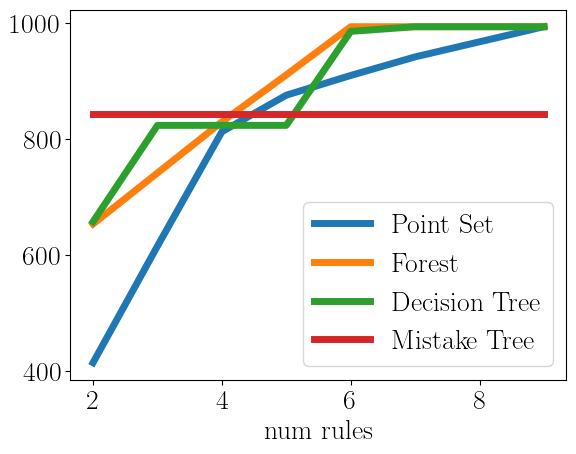

In [31]:
fix, ax = plt.subplots()
ax.plot(rule_range, rule_evals, linewidth = 5, label = 'Point Set')
ax.plot(rule_range, forest_rule_evals, linewidth = 5, label = 'Forest')
ax.plot(rule_range, decision_tree_rule_evals, linewidth = 5, label = 'Decision Tree')
ax.plot(rule_range, explanation_tree_rule_evals, linewidth = 5, label = 'Mistake Tree')
ax.set_xlabel('num rules')
plt.legend()